In [79]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import datetime
import random
import string
import matplotlib.pyplot as plt
import seaborn as sns

from numba import jit
from multiprocessing import cpu_count
from dask.multiprocessing import get
from dask import set_options
from functools import reduce

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go

# output to notebook
init_notebook_mode(True)

nCores = cpu_count()
sns.set()
set_options(get=dask.get)

# parameters for generating data
row_range = 10 ** np.arange(4,8)
startdate = datetime.date(1900,1,1)

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Initializing Data

The computer I primarily use has 32GB of RAM (DDR4-3200,CAS14).  Additionally, I created a 64GB swap file partition on a Samsung 960 Evo M.2 Flash Drive (if anyone has any experience using Intel Optane drive for this, let me know about your experiences).  I wanted to create a dataframe that exceeded 32GB in memory to test the efficacy of Pandas vs Dask vs Spark.  The following parameters should accomplish that with 100 million rows.

The "data" contains a random date between 1900 and 2000, a random float between 0 and 1, a random int between 0 and 3333, and a "categorical" string of [a-z].

The random int column, c2, contains NaN values, 10% of the total.

The categorical column, c3, also contains NaN values, 10% of the total.

In [28]:
def gen_data(nRows, startdate):
    # generate random data
    c1 = np.random.rand(nRows)
    c2 = np.random.randint(0,3333,nRows)
    c3 = np.random.choice(['a','b','c','d','e',
               'f','g','h','i','j',
               'k','l','m','n','o',
               'p','q','r','s','t',
               'u','v','w','x','y','z'],size=nRows)
    date = [startdate + datetime.timedelta(int(i)) for i in np.random.randint(1,36524,size=nRows)]
    data = pd.DataFrame({'date':date,
                         'c1':c1,
                         'c2':c2,
                         'c3':c3
                        })
    data.date = pd.to_datetime(data.date)

    # picking random null values
    data.loc[data.sample(frac=.1).index,'c2'] = np.nan
    data.loc[data.sample(frac=.1).index,'c3'] = np.nan
    
    return data

## Python, Pandas, Single-Processor

The following function extracts the various parts of time from a datetime column and returns the original dataframe with the new features:

In [29]:
def date_extractor(df, dateCol='date', interval=['year','month','week','day','dayofweek']):
    '''
    input: dataframe, column of datetime objects, desired list of time-interval features
    output: dataframe with new time-interval features appended
    '''
    df.is_copy = False # we're not dealing with copies, this avoids the warning
    for i in interval:
        df.loc[:, i] = eval('df.%s.dt.%s'% (dateCol, i))
    df.drop(dateCol, axis=1, inplace=True)
    
    return df

This next function fills our missing values and creates an addition feature: `feat_isnull`

In [30]:
def impute_null(df, cols):
    '''
    input: dataframe, numerical columns with null values
    output: dataframe with null values imputed with mean and a new feature indicating that entry was null
    '''
    df.is_copy = False # we're not dealing with copies, this avoids the warning
    for col in cols:
        # creating the new feature which indicates isnull
        feat_is_null = col + '_isnull'
        df.loc[:, feat_is_null] = np.int8(df[col].isnull())
        
         # imputing median
        impute_value = np.nanmean(df[col])
        df.loc[:, col].fillna(impute_value, inplace=True)
    
    return df

For categorical features, we'll treat them slightly differently by passing a string we wish to use as a null placeholder.

In [31]:
def impute_null_cat(df, cols, naStr):
    '''
    input: dataframe, categorical column with null values, string to signify missing value
    output: dataframe with null values imputed with 'UNK' and a new feature indicating entry was null
    '''
    df.is_copy = False # we're not dealing with copies, this avoids the warning
    for col in cols:
        # creating the new feature which indicates isnull
        feat_is_null = col + '_isnull'
        df.loc[:, feat_is_null] = np.int8(df[col].isnull())
        
        # imputing missing code
        df.loc[:, col].fillna(naStr, inplace=True)
        
    return df

The following functions deal with encoding categorical features.  We will not be using the sklearn encoder as it has issues dealing with previously unseen values.  For example, let's say you have a feature with 6 levels: `{A, B, C, D, E, F}`, however, `F` is relatively rare.  After creating a validation set, it turns out that `F` is not seen in the `x_train` but is in `x_valid`.  

Sklearn's encoder may not be able to "train" on `x_train` and properly convert `x_valid` due to the varying number of values.  In the functions below, instead, we pass `unkStr` to recode a previously unseen value.  For this example, we will encode these as we did missing values.

In [32]:
def cat_encode_train(df, col, unkStr):
    '''
    input: dataframe, name of single categorical column
    output: dictionary representing previous levels and new numerical encodings
    '''
    keys = set(df[col])
    keys.add(unkStr)
    values = np.arange(0, len(keys)+1)
    
    return dict(zip(keys,values))


def cat_encoder(df, col, dict_enc, unkStr):
    '''
    input: dataframe, name of single categorical column, dictionary of encodings, string to use as unknown
    output: dataframe with categorical values encoded
    note: you probably want to match the unknown str with the string used as null in impute_null_cat
    '''
    df.is_copy = False # we're not dealing with copies, this avoids the warning
    # need to replace unknown values with unkStr
    df.loc[~df[col].isin(set(dict_enc.keys())), col] = unkStr

    df.loc[:,col] = df.loc[:,col].map(lambda x : dict_enc[x])
    
    return df

## Dask, Multi-Processor

For this next section, we'll be using map_partitions to apply the previous written functions across data sets to parallelize their operations.  While we could re-write these functions, this is the quickest way to get the benefit of multi-core parallel operation.  However, we're going to have to rewrite our `impute_null()` and `cat_encoder()` functions due to the distributed nature of Dask.

For imputing the mean on a continuous variable, we'll need to collect all possible values and calculate the mean (instead of taking the mean across partitions, and finding the mean of that).  This next block illustrate that these are not guaranteed to be equivalent values:

In [33]:
test = np.random.rand(10)
test2 = np.random.rand(10)
test3 = np.random.rand(20)

# Mean of means
print('Mean of means: %s' % np.mean([np.mean(test), np.mean(test2), np.mean(test3)]))

# Mean of all values
print('Mean of all values: %s' % (np.sum([np.sum(test),np.sum(test2),np.sum(test3)]) / 40))

Mean of means: 0.4617388140848371
Mean of all values: 0.45466652304854555


In [34]:
def impute_null_dask(dd, cols):
    '''
    input: dask dataframe, numerical columns with null values
    output: dask dataframe with null values imputed with mean and a new feature indicating that entry was null
    '''
    #dd.is_copy = False # we're not dealing with copies, this avoids the warning
    for col in cols:
        # creating the new feature which indicates isnull
        feat_is_null = col + '_isnull'
        
        # unfortunately, have to use some trickery here as the new column assignment is not a string
        eval('dd.assign(%s=data.loc[:,"%s"].isnull().astype(np.uint8))' % (feat_is_null, col))
        
         # we're going to have to aggregate with a tuple to get both the total sum and number of rows
        sum_len = dd.loc[:,col].map_partitions(lambda x : (np.nansum(x), len(x))).compute()
        sum_len = reduce(lambda x, y : (x[0] + y[0], x[1] + y[1]), sum_len)
        impute_val = sum_len[0] / sum_len[1]
        dd = data.map_partitions(lambda df : df.loc[:,col].fillna(impute_val))
    
    return dd  

Our label encoder takes all of the possible values within a feature and creates a numerical mapping.  However, since our data will be split randomly into parititons, we cannot be certain that each partition will have an identical set of values.  In this example, I split the data into 12 partitions, but for this function, I do not want 12 potential encodings.

We'll change the function to, instead, aggregate all the potential encodings before creating a numerical mapping.

In [38]:
def cat_encode_train_dask(dd, col, unkStr):
    '''
    input: Dask Dataframe
    output: Dictionary containing categorical-to-numerical mappings
    note: Need to be careful to grab all potential mappings across all partitions
    '''
    tmp_ = dd.map_partitions(lambda df : set(df[col])).compute()
    keys = reduce(lambda x, y : x | y, tmp_)
    keys.add(unkStr)
    values = np.arange(0, len(keys)+1)
    
    return dict(zip(keys,values))

## Spark

For this section, we will need to rewrite much of the previous work to utilize Spark.  Additionally, we'll need to configure the various components of Spark when we initialize a Spark Context.

Much like Python, datetime objects in Spark can be split into their constituent components.  Unfortunately, not every piece behaves like its Python counterpart.  In our case, the default 'dayofweek' will be encoded as a string `'Sunday', 'Monday',...` when we want integers `0, 1,...`.  Also unfortunate, changing data types is not the easiest thing in the world for a Spark Data Frame, but we can use `select` and `cast` to take care of it.

In [39]:
def spark_date_extractor(sdf, dateCol):
    '''
    input: Spark dataframe, column of datetime objects
    output: Spark dataframe with new time-interval features appended
    notes: Unfortunately, there's a lot of hard coding here for the individual features
    ''' 
    str_to_int = {
              'Sunday':'0', 
              'Monday':'1',
              'Tuesday':'2',
              'Wednesday':'3',
              'Thursday':'4',
              'Friday':'5',
              'Saturday':'6',
             }
    
    sdf = sdf.\
    withColumn('year', year(dateCol)).\
    withColumn('month', month(dateCol)).\
    withColumn('day', dayofmonth(dateCol)).\
    withColumn('week', weekofyear(dateCol)).\
    withColumn('dayofweek', date_format(dateCol,'EEEE')).\
    na.replace(str_to_int, 1, 'dayofweek').\
    selectExpr('c1', 'c2', 'c3', 'year', 'month', 'day', 'week', 'cast(dayofweek as int) dayofweek')
    
    return sdf

Since we're using the mean value to impute missing continuous values, we'll want to collect all possible values across the partition first as this simple 

In [40]:
def spark_impute_null(sdf, cols):
    '''
    input: Spark Dataframe, numerical columns missing values
    output: Spark Dataframe with missing values filled with mean
    '''
    for col in cols:
        value = sdf.\
                filter(~isnan(col)).\
                select(avg(col)).\
                head()[0]
        
        sdf = sdf.na.fill({col:value})
    
    return sdf


def spark_impute_null_cat(sdf, cols, unkStr):
    '''
    input: Spark Dataframe, categorical columns missing values, new value for missing
    output: Spark Dataframe with missing value replaced with unkStr
    '''
    for col in cols:
        sdf = sdf.withColumn(col, regexp_replace(col, 'NaN', 'UNK'))
    
    return sdf

Much like in Dask, we'll need to be sure to gather all possible values across the partitions.

In [41]:
def spark_cat_encode_train(sdf, col, unkStr):
    '''
    input: spark data frame, col to encode, unkStr to append for future unknowns
    output: dictionary containing previous values and numeric encodings
    '''
    keys = sdf.select(col).rdd.reduce(lambda x, y : set(x) | set(y))
    keys.add(unkStr)
    values = np.arange(0, len(keys)+1).astype(str)
    
    return dict(zip(keys,values))
    
def spark_cat_encoder(sdf, col, dict_enc, unkStr):
    '''
    input: spark dataframe, col to encode, dictionary of encodings, unkStr for unknowns
    output: spark dataframe with string column encoded as integer
    '''
    # need to recode unknown values to unkStr
    cast_unk = udf(lambda x : unkStr if x not in dict_enc else x, StringType())
    sdf = sdf.withColumn(col, cast_unk(col))
    
    # now make the replacement according to dict_enc
    sdf = sdf.na.replace(dict_enc, 1, col)
    # need this monstrosity to select all cols with col recast as int
    sdf = eval('sdf.selectExpr("'+\
               '","'.join(['cast(%s as int) %s' % (i,i) if i == col else i for i in sdf.columns])+\
               '")'
              )
    
    return sdf

## Testing

In [58]:
results_py = pd.DataFrame(columns = [
                                     'date',
                                     'impute',
                                     'encode',
                                     'total',
                                     'nRows',
                                     'memory'
                                    ])

for i,nIter in enumerate(row_range): 
    data = gen_data(nIter, startdate)
    out1_, out2_, out3_ = 0, 0, 0
    # date features
    print('Size: %s'% nIter)
    tmp_ = %timeit -n 1 -r 1 -o date_extractor(data, 'date')
    out1_ = tmp_.average
    
    # imputing nulls
    tmp_ = %timeit -n 1 -r 1 -o impute_null(data, ['c2'])
    out2_ = tmp_.average
    tmp_ = %timeit -n 1 -r 1 -o impute_null_cat(data, ['c3'], 'UNK')
    out2_ += tmp_.average
    
    # encode cat features
    tmp_ = %timeit -n 1 -r 1 -o cat_encode_train(data, 'c3', 'UNK')
    out3_ = tmp_.average
    dict_ = cat_encode_train(data, 'c3', 'UNK')
    tmp_ = %timeit -n 1 -r 1 -o cat_encoder(data, 'c3', dict_, 'UNK')
    out3_ += tmp_.average
    
    row = {'date':out1_,
           'impute':out2_,
           'encode':out3_,
           'total':out1_ + out2_ + out3_,
           'nRows':nIter,
           'memory':data.memory_usage().sum() / 1e6
          }
    
    results_py.loc[i] = row

Size: 10000
9.08 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.65 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.12 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
165 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
6.63 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Size: 100000
39 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.78 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.03 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
36.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Size: 1000000
340 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
17.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
73.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
334 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loo

In [59]:
results_dd = pd.DataFrame(columns = [
                                     'date',
                                     'impute',
                                     'encode',
                                     'total',
                                     'nRows'
                                    ])

for i,nIter in enumerate(row_range): 
    data_ = gen_data(nIter, startdate)
    data = dd.from_pandas(data_, npartitions=nCores)
    out1_, out2_, out3_ = 0, 0, 0
    print('Size: %s'% nIter)
    # date features
    tmp_ = %timeit -n 1 -r 1 -o  data.\
                                    map_partitions(lambda df : date_extractor(df,'date')).\
                                    compute()
    time_date = tmp_.average
    
    # impute nulls
    tmp_ = %timeit -n 1 -r 1 -o  impute_null_dask(data, ['c2']).compute()
    time_null = tmp_.average
    
    data = dd.from_pandas(data_, npartitions=nCores)
    tmp_ = %timeit -n 1 -r 1 -o  data.\
                                    map_partitions(lambda df : impute_null_cat(df, ['c3'], 'UNK')).\
                                    compute()
    time_null_cat = tmp_.average
    
    # encode cat features
    data = dd.from_pandas(data_, npartitions=nCores)
    data = data.map_partitions(lambda df : impute_null_cat(df, ['c3'], 'UNK'))
    tmp_ = %timeit -n 1 -r 1 -o cat_encode_train_dask(data, 'c3','UNK')
    time_dict = tmp_.average
    
    dict_ = cat_encode_train_dask(data.\
                                   map_partitions(lambda df : impute_null_cat(df, ['c3'], 'UNK')),
                                  'c3',
                                  'UNK')
    data = dd.from_pandas(data_, npartitions=nCores)
    tmp_ = %timeit -n 1 -r 1 -o data.\
                                    map_partitions(lambda df : date_extractor(df,'date')).\
                                    map_partitions(lambda df : impute_null(df, ['c2'])).\
                                    map_partitions(lambda df : impute_null_cat(df, ['c3'], 'UNK')).\
                                    map_partitions(lambda df: cat_encoder(df, 'c3', dict_, 'UNK')).\
                                    compute()
    time_encode = tmp_.average
    
    row = {'date':time_date,
           'impute':time_null + time_null_cat,
           'encode':time_encode + time_dict - time_null - time_null_cat - time_null_cat - time_date,
           'total':time_encode + time_dict - time_null_cat,
           'nRows':nIter,
          }
    
    results_dd.loc[i] = row

Size: 10000
81 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
15.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
22.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
17.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
160 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Size: 100000
110 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
16.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
29.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
24.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
225 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Size: 1000000
429 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
22 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
103 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
95 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
937 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each

In [60]:
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *

conf = SparkConf().\
        setMaster('local[*]').\
        setAppName('parallel_preprocessing').\
        set('spark.dynamicAllocation.enabled', 'true')

sc = SparkContext.getOrCreate(conf=conf)
sqc = SQLContext.getOrCreate(sc)
sqc.sql("set spark.sql.shuffle.partitions=6")

results_sp = pd.DataFrame(columns = [
                                     'date',
                                     'impute',
                                     'encode',
                                     'total',
                                     'nRows'
                                    ])

data_schema = StructType([
                          StructField('c1',DoubleType(),True),
                          StructField('c2',DoubleType(),True),
                          StructField('c3',StringType(),True),
                          StructField('date',DateType(),True)
                         ])

for i,nIter in enumerate(row_range): 
    data = gen_data(nIter, startdate)
    data = sqc.createDataFrame(data,data_schema)
    out1_, out2_, out3_ = 0, 0, 0
    print('Size: %s'% nIter)
    # date features
    tmp_ = %timeit -n 1 -r 1 -o spark_date_extractor(data, 'date').collect()
    out1_ = tmp_.average
    
    # impute nulls
    tmp_ = %timeit -n 1 -r 1 -o spark_impute_null(data, ['c2']).collect()
    out2_ = tmp_.average
    tmp_ = %timeit -n 1 -r 1 -o spark_impute_null_cat(data, ['c3'], 'UNK').collect()
    out2_ += tmp_.average
    
    # encode cat features
    tmp_ = %timeit -n 1 -r 1 -o spark_cat_encode_train(data, 'c3', 'UNK')
    out3_ = tmp_.average
    dict_ = spark_cat_encode_train(data, 'c3', 'UNK')
    tmp_ = %timeit -n 1 -r 1 -o spark_cat_encoder(data, 'c3', dict_, 'UNK').collect()
    out3_ += tmp_.average
    
    row = {'date':out1_,
           'impute':out2_,
           'encode':out3_,
           'total':out3_+out2_+out1_,
           'nRows':nIter,
          }
    
    results_sp.loc[i] = row

Size: 10000


/home/imarobit/spark/python/pyspark/sql/dataframe.py:1431: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


1.67 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
779 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
199 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
200 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/imarobit/spark/python/pyspark/sql/dataframe.py:1431: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


493 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Size: 100000


/home/imarobit/spark/python/pyspark/sql/dataframe.py:1431: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


703 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
805 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
660 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
208 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/imarobit/spark/python/pyspark/sql/dataframe.py:1431: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


1.01 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Size: 1000000


/home/imarobit/spark/python/pyspark/sql/dataframe.py:1431: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


4.22 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
6.05 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.22 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/imarobit/spark/python/pyspark/sql/dataframe.py:1431: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


7.36 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Size: 10000000


/home/imarobit/spark/python/pyspark/sql/dataframe.py:1431: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")
----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 43354)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/socketserver.py", line 696, in __init__
    self.handle()
  File "/home/imarobit/s

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34473)
Traceback (most recent call last):
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-317f4071760e>", line 32, in <module>
    tmp_ = get_ipython().run_line_magic('timeit', "-n 1 -r 1 -o spark_date_extractor(data, 'date').collect()")
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2095, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-61>", line 2, in timeit
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/imarobit/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1102, in timei

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:34473)

In [61]:
results_py.to_feather('py_results')

In [62]:
results_dd.to_feather('dd_results')

In [63]:
results_sp.to_feather('sp_results')

In [67]:
results_py

,date,impute,encode,total,nRows,memory
0,0.009082,0.003766,0.006799,0.019648,10000.0,0.66008
1,0.038953,0.011879,0.037624,0.088456,100000.0,6.60008
2,0.340248,0.090996,0.344405,0.775650,1000000.0,66.00008
3,4.633679,1.168647,3.824533,9.626858,10000000.0,660.00008


In [68]:
results_dd

,date,impute,encode,total,nRows
0,0.080962,0.037824,0.035990,0.154775,10000.0
1,0.109699,0.045962,0.064066,0.219727,100000.0
2,0.429397,0.124537,0.375819,0.929753,1000000.0
3,3.584429,1.010302,3.269169,7.863899,10000000.0


In [69]:
results_sp

,date,impute,encode,total,nRows
0,1.669281,0.978210,0.693174,3.340665,10000.0
1,0.703422,1.465392,1.220482,3.389295,100000.0
2,4.216003,11.273795,8.615357,24.105155,1000000.0


In [21]:
import seaborn as sns

sns.set(style='darkgrid')
sns.set(rc={'figure.figsize':(16,9)})

In [72]:
results_py.iloc[0,0:3]

date      0.009082
impute    0.003766
encode    0.006799
Name: 0, dtype: float64

In [88]:
all_trace = []

# Python
trace = go.Bar(
       x=['Dates','Nulls','Encode'],
       y=results_py.iloc[0,0:3],
       name='Python',
       marker=dict(color='rgb(120,200,120)')
      )
all_trace.append(trace)

# Dask
trace = go.Bar(
       x=['Dates','Nulls','Encode'],
       y=results_dd.iloc[0,0:3],
       name='Dask',
       marker=dict(color='rgb(1,80,200)')
      )
all_trace.append(trace)

# Spark
trace = go.Bar(
       x=['Dates','Nulls','Encode'],
       y=results_sp.iloc[0,0:3],
       name='Spark',
       marker=dict(color='rgb(120,120,200)')
      )
all_trace.append(trace)

layout = go.Layout(barmode='group')
    
fig = dict(data=all_trace, layout=layout)
iplot(fig)

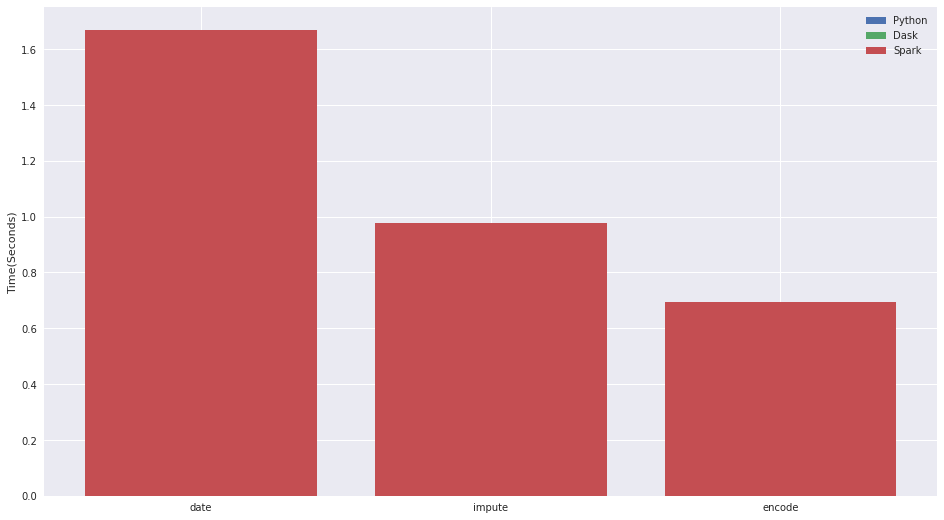

In [73]:
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(results_py.iloc[0,0:3].index, results_py.iloc[0,0:3],label='Python')
ax.bar(results_dd.iloc[0,0:3].index, results_dd.iloc[0,0:3],label='Dask')
ax.bar(results_sp.iloc[0,0:3].index, results_sp.iloc[0,0:3],label='Spark')
#ax.set_xlabel("Rows")
ax.set_ylabel("Time(Seconds)")
ax.legend()
plt.show()
fig.savefig('./images/01.png',dpi=300)

In [ ]:
crime_mon = data.groupby(['month','year']).IncidntNum.sum()

all_trace = []

for i,v in enumerate(set(crime_mon.index.levels[1])):
    trace = go.Bar(
           x=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
           y=crime_mon[:,v],
           name='Year: %s' % v,
           marker=dict(color='rgb(%s,%s,%s)' % (i*20,i*20,(100 + i * 20)))
          )
    all_trace.append(trace)

# adding mean
all_trace.append(go.Bar(
                        x=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                        y=data.groupby('month').IncidntNum.sum()/10,
                        name='Avg',
                        marker=dict(color='rgb(200,20,20)')
                       ))
    
layout = go.Layout(barmode='group')
    
fig = dict(data=all_trace, layout=layout)
iplot(fig)

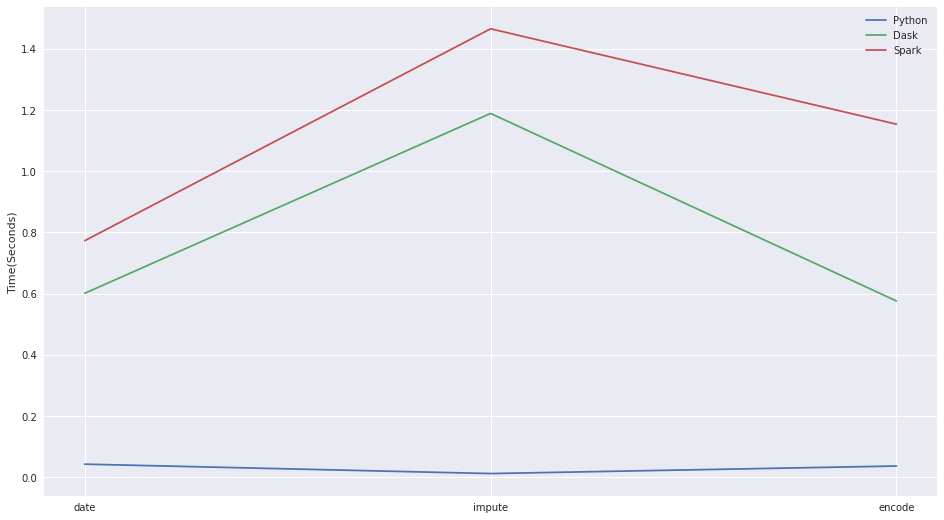

In [23]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(results_py.iloc[1,0:3],label='Python')
ax.plot(results_dd.iloc[1,0:3],label='Dask')
ax.plot(results_sp.iloc[1,0:3],label='Spark')
#ax.set_xlabel("Rows")
ax.set_ylabel("Time(Seconds)")
ax.legend()
plt.show()
fig.savefig('./images/02.png',dpi=300)


In [ ]:
from multiprocessing import cpu_count, Pool
 
#cores = cpu_count() #Number of CPU cores on your system
#partitions = 12 #Define as many partitions as you want
 
def parallelize(data, func, partitions):
    data_split = np.array_split(data, partitions)
    pool = Pool(partitions)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data